In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier too slow for large datasets
from sklearn.metrics import accuracy_score,confusion_matrix
from xgboost import XGBClassifier

In [2]:
raw_data=pd.read_csv('..\\datasets\\Fraud-Detection\\FraudDetection.csv')
#dataset url https://www.kaggle.com/datasets/ealaxi/paysim1
#Synthetic Financial Datasets For Fraud Detection

In [3]:
data=raw_data.copy()

In [4]:
raw_data.isnull().sum() #check if there is any NULL value in the dataset

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

([<matplotlib.patches.Wedge at 0x1bca4e9d240>,
 [Text(0.49426122663384003, 0.9827033325711335, 'CASH_OUT'),
  Text(-1.0906766219942048, -0.1429143318051433, 'PAYMENT'),
  Text(0.3384112332518691, -1.046650771369777, 'CASH_IN'),
  Text(1.0495474656709025, -0.3293176541028222, 'TRANSFER'),
  Text(1.0997698357971, -0.022501294869852733, 'DEBIT')])

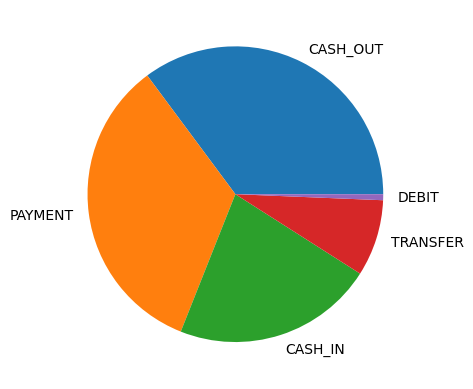

In [5]:
type=raw_data['type'].value_counts()
typeLabels=type.index
typeNumbers=type.values

fig,ax=plt.subplots()
ax.pie(typeNumbers,labels=typeLabels)
#check transcation types and plot in pie chart for visualization

In [6]:
correlation=raw_data.corr(numeric_only=True)
print(correlation['isFraud'].sort_values(ascending=False))
#check correlation for features, print out correlation with isFraud column to see which column is most related to fraud, turns out to be the amount

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


In [7]:
data['type']=data['type'].map({
    'CASH_OUT':1,
    'PAYMENT':2,
    'CASH_IN':3,
    'TRANSFER':4,
    'DEBIT':5
})

In [ ]:
data['isFraud']=data['isFraud'].map({0:'Not Fraud',1:'Fraud'})
#map categorical column with numerical numbers, also map isFruad column just for easy identify

In [12]:
data[data['isFraud']=='Fraud'].shape[0]/data[data['isFraud']=='Not Fraud'].shape[0]
#check percentage of fraud transcations to non-fraud transactions, the dataset is quite unbalanced

0.0012924888191769902

In [8]:
x=np.array(data[['type','amount','oldbalanceOrg','newbalanceOrig']])
y=np.array(data[['isFraud']])
#only pick 4 most correlated columns

In [9]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.1,random_state=365)

In [11]:
model=DecisionTreeClassifier()
model.fit(xtrain,ytrain)
print(model.score(xtest,ytest))

0.9997422445470576


In [19]:
xgb=XGBClassifier()
xgb.fit(xtrain,ytrain)
print(xgb.score(xtest,ytest))

0.999578789869582


In [21]:
ypred=model.predict(xtest)
#make prediction on xtest data
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))

0.9997422445470576
[[635359     87]
 [    77    739]]


In [20]:
ypred=xgb.predict(xtest)
#make prediction on xtest data
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))

0.999578789869582
[[635373     73]
 [   195    621]]


In [15]:
#precision=TP/(TP+FP)
TP=confusion_matrix(ytest,ypred)[0][0] #True Positive
FP=confusion_matrix(ytest,ypred)[1][0] #False Positive
FN=confusion_matrix(ytest,ypred)[0][1] #False Negative
TN=confusion_matrix(ytest,ypred)[1][1] #True Negative

print("Percision is : ",TP/(TP+FP))
print("Specificity is : ",TN/(FP+TN))
print("Recall is : ",TP/(TP+FN))

Percision is :  0.8948004836759371
Specificity is :  0.9998630882875964
Recall is :  0.9068627450980392


Anything we can do to improve accuracy?

In [16]:
from sklearn import preprocessing

In [17]:
xtrain_std=preprocessing.scale(xtrain[:,1:])
xtrain_std=np.append(xtrain[:,0:1],xtrain_std,axis=1)
xtest_std=preprocessing.scale(xtest[:,1:])
xtest_std=np.append(xtest[:,0:1],xtest_std,axis=1)

C:\Users\shich\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\shich\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [18]:
print(model.score(xtest_std,ytest))

0.28854779949140447


In [19]:
ypred=model.predict(xtest_std)
print(confusion_matrix(ytest,ypred))

[[   269    547]
 [452123 183323]]


standardize does not help improve accuracy which makes sense because the fraud is related to absolute number of the transaction amount instead of relative number, also, decision tree algorithm does not require scale or standardize data. next I am going to try balance the dataset a little bit

In [20]:
num_fraud=y[y=='Fraud'].shape[0]

In [21]:
not_fraud_counter=0
indices_to_remove=[]
for i in range(x.shape[0]):
    if y[i]=='Not Fraud':
        not_fraud_counter+=1
        if not_fraud_counter>num_fraud:
            indices_to_remove.append(i)
x_balanced=np.delete(x,indices_to_remove,axis=0)
y_balanced=np.delete(y,indices_to_remove,axis=0)

In [22]:
x_balanced.shape

(16426, 4)

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(x_balanced,y_balanced,test_size=0.1,random_state=365)

In [24]:
model.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [25]:
ypred=model.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))

0.995739500912964
[[810   3]
 [  4 826]]


In [26]:
#precision=TP/(TP+FP)
TP=confusion_matrix(ytest,ypred)[0][0] #True Positive
FP=confusion_matrix(ytest,ypred)[1][0] #False Positive
FN=confusion_matrix(ytest,ypred)[0][1] #False Negative
TN=confusion_matrix(ytest,ypred)[1][1] #True Negative

print("Percision is : ",TP/(TP+FP))
print("Specificity is : ",TN/(FP+TN))
print("Recall is : ",TP/(TP+FN))

Percision is :  0.995085995085995
Specificity is :  0.9951807228915662
Recall is :  0.996309963099631


As we can see here, balance dataset helps improve overall performance a lot, the percision rate is increased from 89.5% to 99.5%, this is related to not only more balanced data, but also related to simpler decision tree. Next I am going to change to LogisticRegression model to see which one is better

In [27]:
from sklearn.linear_model import LogisticRegression

In [42]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.1,random_state=365)
linearModel=LogisticRegression()
linearModel.fit(xtrain,ytrain)
print(linearModel.score(xtest,ytest))

C:\Users\shich\anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9995206377247109


In [43]:
ypred=linearModel.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))

0.9995206377247109
[[   800     16]
 [   289 635157]]


In [37]:
#precision=TP/(TP+FP)
TP=confusion_matrix(ytest,ypred)[0][0] #True Positive
FP=confusion_matrix(ytest,ypred)[1][0] #False Positive
FN=confusion_matrix(ytest,ypred)[0][1] #False Negative
TN=confusion_matrix(ytest,ypred)[1][1] #True Negative

print("Percision is : ",TP/(TP+FP))
print("Specificity is : ",TN/(FP+TN))
print("Recall/Sensitivity is : ",TP/(TP+FN))

Percision is :  0.7570093457943925
Specificity is :  0.6867469879518072
Recall/Sensitivity is :  0.996309963099631


As we can see here, logistic regression pick Ture Positive (Fraud) quite well while lots of not Fraud is false alarmed, next we are going to balance the dataset

In [34]:
xtrain,xtest,ytrain,ytest=train_test_split(x_balanced,y_balanced,test_size=0.1,random_state=365)

In [35]:
linearModel.fit(xtrain,ytrain)
print(linearModel.score(xtest,ytest))

0.8399269628727937


C:\Users\shich\anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
ypred=linearModel.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))

0.8399269628727937
[[810   3]
 [260 570]]


Samet hing here, the algorithm identified most of the fraud, however lots of not-fraud are identified as fraud too.